In [1]:
import requests
import json
import csv
import time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error

from tensorflow import config
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import LSTM, Dense, InputLayer
from keras.callbacks import EarlyStopping

In [2]:
config.list_logical_devices()

[LogicalDevice(name='/device:CPU:0', device_type='CPU'),
 LogicalDevice(name='/device:GPU:0', device_type='GPU')]

# Get the data from Binance api

## Get

In [3]:
# You can create 'api_key.txt' file with your api key inside it (it's already in '.gitignore')
# or just replace 'api_key.txt' => '{your_api_key}'
api_key = open('api_key.txt', 'r').read()

url = 'https://api.binance.com/api/v3/klines'

symbol =  'BTCUSDT'
interval =  '1h'
limit = 1000
headers = {
    'X-MBX-APIKEY': api_key
}

# Get current date, 4 years ago
start_time = int((time.time() - 126230400) * 1000) # 126230400 seconds = 4 years
end_time = int(time.time() * 1000)

results = []

# Loop through the data until there is no more left
while True:
    # Initial request
    params = {
        'symbol': symbol, 
        'interval': interval, 
        'startTime': start_time, 
        'endTime': end_time, 
        'limit': limit
    }
    response = requests.get(url, headers=headers, params=params)

    # Check if there is any data left
    if not response.json():
        break

    # Add the data to results
    results.extend(response.json())

    # Set the start time for the next request
    start_time = int(results[-1][0]) + 1


## Define dataframe columns and create datafile

In [4]:
columns = ['open_time', 'open_price', 'high_price', 'low_price',
            'close_price', 'Volume', 'close_time', 'quote_asset_volume',
            'number_of_trades', 'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume', 'ignore']

df = pd.DataFrame(results, columns=columns)


In [5]:
df = df[['open_time', 'open_price']]

with open('data.csv', 'w') as file:
    file.write(df.to_csv())

In [6]:
df

,open_time,open_price
0,1556139600000,5409.00000000
1,1556143200000,5399.23000000
2,1556146800000,5413.32000000
3,1556150400000,5415.00000000
4,1556154000000,5426.98000000
...,...,...
35005,1682352000000,27267.06000000
35006,1682355600000,27110.56000000
35007,1682359200000,27381.48000000
35008,1682362800000,27339.91000000


# Preparing data

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35010 entries, 0 to 35009
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   open_time   35010 non-null  int64 
 1   open_price  35010 non-null  object
dtypes: int64(1), object(1)
memory usage: 547.2+ KB


### Split df to dates and prices

In [8]:
df_dates = df['open_time']
df_prices = df['open_price']

In [9]:
df_prices

0         5409.00000000
1         5399.23000000
2         5413.32000000
3         5415.00000000
4         5426.98000000
              ...      
35005    27267.06000000
35006    27110.56000000
35007    27381.48000000
35008    27339.91000000
35009    27383.28000000
Name: open_price, Length: 35010, dtype: object

### Change df_prices type from object to float

In [10]:
df_prices = df_prices.astype(float)

In [11]:
df_prices

0         5409.00
1         5399.23
2         5413.32
3         5415.00
4         5426.98
           ...   
35005    27267.06
35006    27110.56
35007    27381.48
35008    27339.91
35009    27383.28
Name: open_price, Length: 35010, dtype: float64

## Split into training, validation and test

In [12]:
train_valid_border =int(len(df_prices) * 0.65)
valid_test_border = int(len(df_prices) * 0.75)

train, valid, test = np.split(df_prices, [train_valid_border, valid_test_border])

In [13]:
len(train), len(valid), len(test)

(22756, 3501, 8753)

### Save min and max (for 'predict/next_hour_forecasting.ipynb')

In [14]:
with open('./train_min_max_std/min.txt', 'w') as file:
    file.write(str(train.min()))

with open('./train_min_max_std/max.txt', 'w') as file:
    file.write(str(train.max()))

# Scale

In [15]:
scaler = MinMaxScaler()

train_norm = scaler.fit_transform(train.values.reshape(-1, 1))
valid_norm = scaler.fit_transform(valid.values.reshape(-1, 1))
test_norm = scaler.fit_transform(test.values.reshape(-1, 1))

## Plot

Text(0, 0.5, 'Exchange rate BTC to USDT')

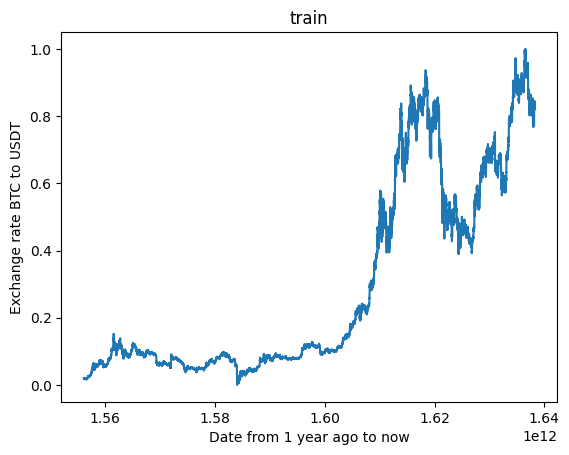

In [16]:
plt.plot(df_dates[:train_valid_border], train_norm)
plt.title('train')
plt.xlabel('Date from 1 year ago to now')
plt.ylabel('Exchange rate BTC to USDT')

Text(0, 0.5, 'Exchange rate BTC to USDT')

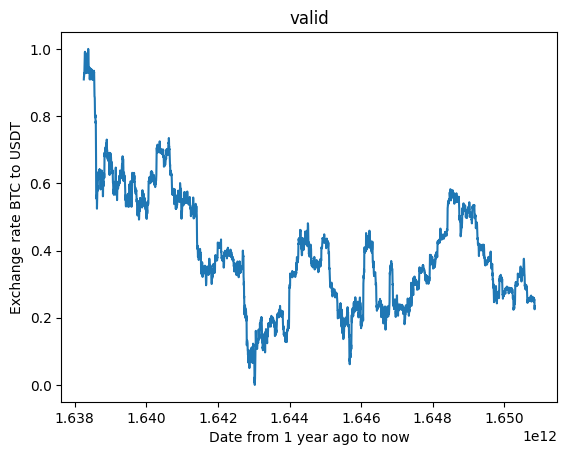

In [17]:
plt.plot(df_dates[train_valid_border:valid_test_border], valid_norm)
plt.title('valid')
plt.xlabel('Date from 1 year ago to now')
plt.ylabel('Exchange rate BTC to USDT')

Text(0, 0.5, 'Exchange rate BTC to USDT')

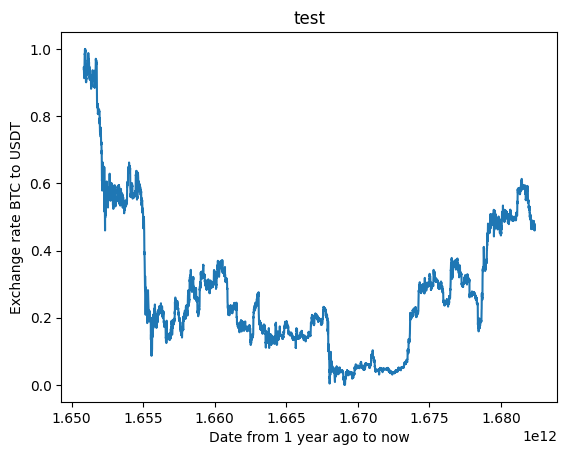

In [18]:
plt.plot(df_dates[valid_test_border:], test_norm)
plt.title('test')
plt.xlabel('Date from 1 year ago to now')
plt.ylabel('Exchange rate BTC to USDT')

# Arrays => X, y  (Time series)

In [19]:
look_back = 720 # x will be last 720 hours for each y

train_gen = TimeseriesGenerator(train_norm, train_norm, length=look_back, batch_size=100)
valid_gen = TimeseriesGenerator(valid_norm, valid_norm, length=look_back, batch_size=1)
test_gen = TimeseriesGenerator(test_norm, test_norm, length=look_back, batch_size=1)

print('Number of batches in train_gen:', train_gen.__len__())

Number of batches in train_gen: 221


### X for first batch in train_gen (as pd dataframe)

In [20]:
pd.DataFrame(train_gen.__getitem__(0)[0][...,0])

,0,1,2,3,4,5,6,7,8,9,...,710,711,712,713,714,715,716,717,718,719
0,0.019809,0.019658,0.019876,0.019902,0.020088,0.020145,0.019731,0.019873,0.019670,0.019769,...,0.061145,0.060270,0.060142,0.059427,0.059496,0.060145,0.060092,0.059620,0.059757,0.058953
1,0.019658,0.019876,0.019902,0.020088,0.020145,0.019731,0.019873,0.019670,0.019769,0.019374,...,0.060270,0.060142,0.059427,0.059496,0.060145,0.060092,0.059620,0.059757,0.058953,0.058960
2,0.019876,0.019902,0.020088,0.020145,0.019731,0.019873,0.019670,0.019769,0.019374,0.019763,...,0.060142,0.059427,0.059496,0.060145,0.060092,0.059620,0.059757,0.058953,0.058960,0.059336
3,0.019902,0.020088,0.020145,0.019731,0.019873,0.019670,0.019769,0.019374,0.019763,0.019717,...,0.059427,0.059496,0.060145,0.060092,0.059620,0.059757,0.058953,0.058960,0.059336,0.060020
4,0.020088,0.020145,0.019731,0.019873,0.019670,0.019769,0.019374,0.019763,0.019717,0.019654,...,0.059496,0.060145,0.060092,0.059620,0.059757,0.058953,0.058960,0.059336,0.060020,0.060678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.017982,0.017810,0.017902,0.018322,0.018271,0.018512,0.018400,0.018436,0.018403,0.018542,...,0.070669,0.070711,0.070990,0.070994,0.071091,0.070515,0.070145,0.069960,0.069958,0.068885
96,0.017810,0.017902,0.018322,0.018271,0.018512,0.018400,0.018436,0.018403,0.018542,0.018404,...,0.070711,0.070990,0.070994,0.071091,0.070515,0.070145,0.069960,0.069958,0.068885,0.067019
97,0.017902,0.018322,0.018271,0.018512,0.018400,0.018436,0.018403,0.018542,0.018404,0.018403,...,0.070990,0.070994,0.071091,0.070515,0.070145,0.069960,0.069958,0.068885,0.067019,0.067782
98,0.018322,0.018271,0.018512,0.018400,0.018436,0.018403,0.018542,0.018404,0.018403,0.018142,...,0.070994,0.071091,0.070515,0.070145,0.069960,0.069958,0.068885,0.067019,0.067782,0.068478


### y for first batch in train_gen (as pd dataframe)

In [21]:
pd.DataFrame(train_gen.__getitem__(0)[1])

,0
0,0.058960
1,0.059336
2,0.060020
3,0.060678
4,0.060741
...,...
95,0.067019
96,0.067782
97,0.068478
98,0.069265


# Training

In [22]:
data_dim = 1

model = Sequential()

model.add(InputLayer(input_shape=(look_back, data_dim)))
model.add(LSTM(8))
model.add(Dense(1, activation='linear'))

early_stopping = EarlyStopping(patience=2)

model.compile('adam', loss='mse', metrics=['mae'])

model.fit_generator(train_gen, epochs=10, validation_data=valid_gen, callbacks=early_stopping)

Epoch 1/10


C:\Users\Evgeny\AppData\Local\Temp\ipykernel_16068\1333994285.py:13: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(train_gen, epochs=10, validation_data=valid_gen, callbacks=early_stopping)


221/221 [==============================] - 63s 272ms/step - loss: 0.0158 - mae: 0.0756 - val_loss: 0.0020 - val_mae: 0.0392
Epoch 2/10
221/221 [==============================] - 65s 297ms/step - loss: 8.1363e-04 - mae: 0.0198 - val_loss: 7.0177e-04 - val_mae: 0.0204
Epoch 3/10
221/221 [==============================] - 65s 293ms/step - loss: 2.9485e-04 - mae: 0.0112 - val_loss: 5.2944e-04 - val_mae: 0.0165
Epoch 4/10
221/221 [==============================] - 69s 312ms/step - loss: 1.3423e-04 - mae: 0.0075 - val_loss: 4.5235e-04 - val_mae: 0.0149
Epoch 5/10
221/221 [==============================] - 65s 296ms/step - loss: 1.1330e-04 - mae: 0.0066 - val_loss: 4.8725e-04 - val_mae: 0.0156
Epoch 6/10
221/221 [==============================] - 68s 309ms/step - loss: 8.0354e-05 - mae: 0.0055 - val_loss: 4.4256e-04 - val_mae: 0.0145
Epoch 7/10
221/221 [==============================] - 71s 321ms/step - loss: 7.4772e-05 - mae: 0.0052 - val_loss: 4.5526e-04 - val_mae: 0.0148
Epoch 8/10
221/221

# Test

In [23]:
# loss, mae = model.evaluate_generator(test_gen, steps=len(test_gen))

In [24]:
# print(f'Loss: {loss} \nMean absolute error(mae): {mae}')

In [25]:
y_pred = model.predict_generator(test_gen)


C:\Users\Evgeny\AppData\Local\Temp\ipykernel_16068\1890124827.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  y_pred = model.predict_generator(test_gen)


In [26]:
y_true = test_gen.targets[721:]

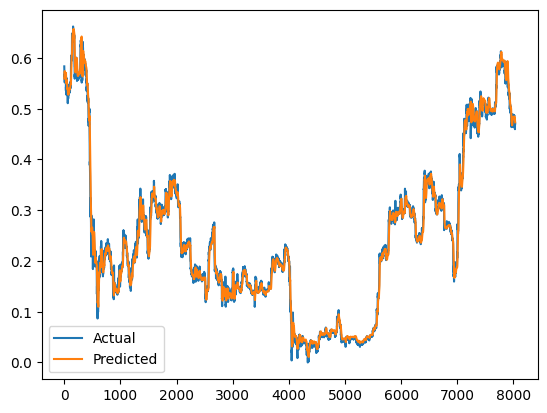

In [27]:
plt.plot(y_true, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend()

# Save model

In [28]:
model.save('./predict/saved_model.h5', save_format='h5')